In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import vlc

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0']

In [13]:
def trainGenerator(case_nums, batch_size, window_step):
    from DataPreprocessor import DataLoader
    dl = DataLoader()
    while True:        
        for case_num in case_nums:
            X_file = np.swapaxes(dl.make_spectrogram(case_num), 0, 1)
            y_age, y_gender = dl.get_labels(case_num)
            L = X_file.shape[0]
            batch_start = 0
            batch_end = batch_size       
            while batch_start < L:
                limit = min(batch_end, L)
                X = X_file[batch_start:limit, :]           
                yield (X, y_age, y_gender)            
                batch_start += window_step #window sliding by half of a window size
                batch_end += window_step

            if case_num == case_nums[-1]:
                break
        break      

In [15]:
input_sequence = []
for x in trainGenerator([123], 200, 200):
    if x[0].shape[0]==200:
        input_sequence.append(x[0])        
input_sequence = tf.stack(input_sequence)
L = input_sequence.shape[1]
n_features = input_sequence.shape[2]
print('L: ', L)
print('n_features: ', n_features)

L:  200
n_features:  1025


In [29]:
input = tf.keras.layers.Input(shape=(L, n_features))
encoder = tf.keras.layers.LSTM(5000, activation='tanh')(input)
# define reconstruct decoder
decoder = tf.keras.layers.RepeatVector(L)(encoder)
decoder = tf.keras.layers.LSTM(5000, activation='tanh', return_sequences=True)(decoder)
decoder = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1025))(decoder)

In [30]:
model = tf.keras.Model(inputs=input, outputs=decoder)
model.compile(optimizer='adam', loss='mse')

In [31]:
model.fit(input_sequence, input_sequence, epochs=500, verbose=1)

ch 260/500
1/1 [==============================] - 0s 4ms/step - loss: 2063.4919
Epoch 261/500
1/1 [==============================] - 0s 5ms/step - loss: 2059.6460
Epoch 262/500
1/1 [==============================] - 0s 4ms/step - loss: 2055.8076
Epoch 263/500
1/1 [==============================] - 0s 4ms/step - loss: 2051.9761
Epoch 264/500
1/1 [==============================] - 0s 5ms/step - loss: 2048.1521
Epoch 265/500
1/1 [==============================] - 0s 4ms/step - loss: 2044.3350
Epoch 266/500
1/1 [==============================] - 0s 4ms/step - loss: 2040.5254
Epoch 267/500
1/1 [==============================] - 0s 4ms/step - loss: 2036.7227
Epoch 268/500
1/1 [==============================] - 0s 5ms/step - loss: 2032.9272
Epoch 269/500
1/1 [==============================] - 0s 5ms/step - loss: 2029.1390
Epoch 270/500
1/1 [==============================] - 0s 4ms/step - loss: 2025.3578
Epoch 271/500
1/1 [==============================] - 0s 4ms/step - loss: 2021.5835
Epoch 2

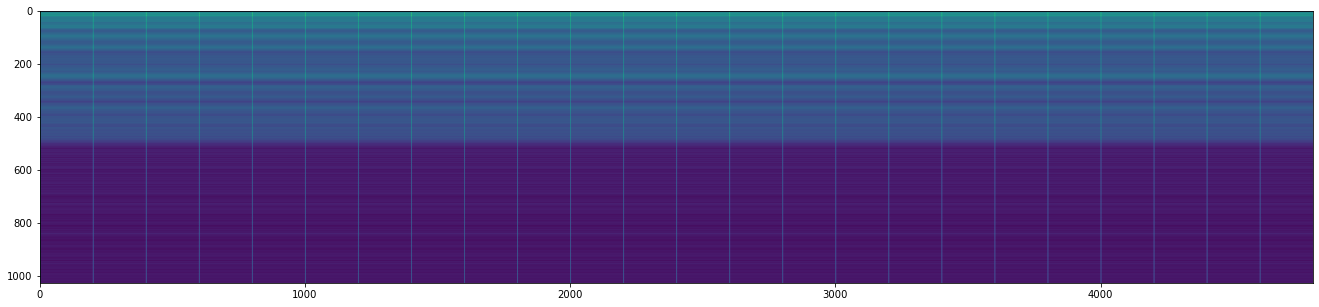

In [32]:
yhat = model.predict(input_sequence, verbose=0)
fig, ax = plt.subplots(figsize=(24, 5))
ax.imshow(np.swapaxes(np.vstack(yhat), 0, 1))